# Sentiment Analysis on Tweets

The purpose of this program is to perform unsupervised natural language processing on tweets for a specified search query. The notebook is broken into the following:

1. Creating the API Object
2. Making calls to the API to create a dataframe
3. Preprocessing data
4. Modeling using HF
5. Modeling using TextBlob
6. Visualization of Results - Graphical
7. Visualization of Results - Numerical
8. Investigating Negative Sentiment but Joy Emotion
9. Discussion and Recommendations

Both _tweepy_ and _twython_ modules were looked at and tested for calling the API object, and both have their respective pros and cons. The vast majority of online examples of connecting the Twitter API used the _tweepy_ module, but the module is currently not being maintained. This notebook specifically uses _tweepy_ despite it not being maintained because it seemed to have the most online support. Slight motifications can use _twython_ instead. 

Data is preprocessed by expanding contractions and removing special characters / hashtags / mentions. Text is forced into lower case during preprocessing. Tokenization, stemming, and lemmatization are all handled using the Hugging Face _AutoTokenizer_ function.

All models were based on the _TweetEVAL_ baseline found in  https://arxiv.org/abs/2010.12421 and made by _cardiffnlp_. The Hugging Face model chosen for sentiment analysis was the RoBERTa-base-sentiment-latest model. The model was trained on ~124M tweets from January 2018 to December 2021, the training set was not specific to financial news / customer service / Regions. The model chosen for emotion analysis was the RoBERTa-base-emotion model trained on ~58M tweets and finetuned for emotion recognition. Other models considered were RoBERTa-base-irony and RoBERTa-base-offensive to detect irony and offensive speech respectively.

TextBlob models for sentiment and subjectivity were added as a comparison benchmark to the Hugging Face models.

## Possible Blockers

- SSL certification error calling the API object when this is done on the Regions network. The notebook can be updated to give the HTTP client access to a trusted certificate store. It should use python’s requests under the hood, which means you installing and using “certifi” and to update the configuration before making calls to tweepy, and everything should work.


- Data streaming is currently impossible of an HTTP error. I believe this is due to the current access level, but there might be a genuine error in the code somewhere I'm missing. It seems that Twitter is also not interested in selling that access to companies (especially with governmental ties).


- Unable to download the different model Config files necessary to use HF pipelines on Regions network. 


- Could potentially need access to the BitBucket to pull additional NLTK functions if necessary (for comparison to HF).


- Currently the install of _transformers_ on Mac M1 Silicon chips does not work without some work arounds (need to install using Rust: https://towardsdatascience.com/hugging-face-transformers-on-apple-m1-26f0705874d7)


In [1]:
# Modules for API
import tweepy
import pandas as pd
import numpy as np
import re
import string

## Modules for tweet streaming
# from tweepy.streaming import Stream
# import json
# from unidecode import unidecode
# import time
# import datetime

# Modules for Hugging Face
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Modules for TextBlob
import textblob

# Modules for Visualizations
import wordcloud 
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

# Creating API Object

In [2]:
# api key
consumer_key = "../key/consumer_key"

# api secret key
consumer_secret = "../key/consumer_secret"

# access token
access_key = "../key/access_key"

# access secret
access_secret = "../key/access.secret"

# Twitter authentication handler
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)   
auth.set_access_token(access_key, access_secret) 
  
# Creating an API object 
api = tweepy.API(auth)

# Creating search terms
search_terms = '"Interest" "FED" -filter:retweets'

In [3]:
# Testing pulling tweets using API from a specific hashtag
tweets = tweepy.Cursor(api.search_tweets, q=search_terms, tweet_mode='extended', lang = "en").items(1)

# Print testing tweet 
for tweet in tweets:
    text = tweet._json["full_text"]
    print(text)
    #using different attributes
    print(tweet.favorite_count)
    print(tweet.retweet_count)
    print(tweet.created_at)

agreed - expect a quick U-turn on interest rates: more increases this year, then cuts next year as the economy weakens https://t.co/0PrcO9l0e1 via @WSJ
0
0
2022-07-25 18:32:53+00:00


In [4]:
#### Data streaming kept returning a error (400). 
#### Likely the access level on the app is too low - need to set up a commercial account for streaming analysis
#### Streaming capabilities are available for NLP analysis on Hugging Face

# ## Code is wrapped in a try/except to prevent potential hiccups from disrupting the stream. 

# ## Documentation recommends using an on_error() function to stop if app is making too many requests.

# ## Stream object in a while condition so it stops if it hits the 420 error.
# ## Sleep to attempt to not hit 420 error.

# # Bearer token should also be written into config file
# bearer_token = "AAAAAAAAAAAAAAAAAAAAAJmldQEAAAAA%2FUH3aWgGE56dtOnt%2B6iwA6RdlCo%3D0VC00ZnjtowhTqTeeQqXvAIGpxyQS7WELraeJYBIrmZkeg11er"

# # Twitter authentication
# auth = tweepy.OAuthHandler(consumer_key, consumer_secret)   
# auth.set_access_token(access_key, access_secret) 

# # Create listener class
# class Listener(Stream):
    
#     def on_data(self, data):
#         try:
#             # Load the json and put into the SQL table
#             data = json.loads(data)
#             tweet = unidecode(data['text'])
#             time_ms = data['timestamp_ms']
#             #print(tweet, time_ms)
#             c.execute("INSERT INTO Tweets (timestamp, tweet) VALUES (?, ?)", (time_ms, tweet))
            
#             conn.commit()
#             time.sleep(2)
            
#         except KeyError as e:
            
#                 print(str(e))
#         return(True)
        
#     def on_error(self, status_code):
#         if status_code == 420:
#             #returning False in on_error disconnects the stream
#             return False
# while True:
#        try:
#             streaming_client = tweepy.StreamingClient(bearer_token)
#             streaming_client.filter(expansions="IHOP")
#        except Exception as e:
#             print(str(e))
#             time.sleep(4)

# Making Tweets Dataframe

In [5]:
# Search Twitter using API calls
# Result type = "mixed" gives popular and recent tweets mixed on timeline.
tweets = tweepy.Cursor(api.search_tweets, 
                       q=search_terms, 
                       tweet_mode='extended', 
                       lang = "en",
                       result_type = "mixed").items(900) 

# Creating tweet object
list = []
for tweet in tweets:
    text = tweet._json["full_text"]

    refined_tweet = {'id' : tweet.id,
                     'full_text' : text,
                     'favorites': tweet.favorite_count,
                     'retweets': tweet.retweet_count,
                     'created_at': tweet.created_at}
    
    list.append(refined_tweet)

df = pd.DataFrame(list)

# Removing any duplicated texts before writing to CSV(sometimes different accounts will post the same thing - common with bots)
df["full_text"].drop_duplicates()

# Save to CSV
## NOTE: Further iterations could have this write back to the data lake for other teams to use
df.to_csv('../data/raw_tweets.csv', mode = "a")

# Show first 5 rows of data
df.head()

,id,full_text,favorites,retweets,created_at
0,1551190468775624706,🇺🇸FEDERAL RESERVE THIS WEEK:\n\n*FED INTEREST ...,806,241,2022-07-24 13:00:02+00:00
1,1551534044768264193,BREAKING: USA INTEREST RATE HIKE WILL LIKELY B...,560,105,2022-07-25 11:45:17+00:00
2,1551564226057076739,This chart basically explaining why all notion...,496,46,2022-07-25 13:45:12+00:00
3,1551636624013934594,agreed - expect a quick U-turn on interest rat...,0,0,2022-07-25 18:32:53+00:00
4,1551636547119697920,"@CryptoCapo_ Or the FED pivots, does not raise...",0,0,2022-07-25 18:32:35+00:00


In [6]:
# Show how many tweets were scraped - should be 900, but can be less depending on how often calls are made
df.count()

id            900
full_text     900
favorites     900
retweets      900
created_at    900
dtype: int64

# Preprocessing

In [13]:
## If you are doing the analysis on the entire dataset you can run this to reload the saved CSV file, otherwise skip this:

# # Pulling in entire called dataset from CSV file where it was written
# df = pd.read_csv('./raw_tweets.csv')

# # Removing any overlapped tweets from last time the API was called
# df["full_text"].drop_duplicates()

0      🇺🇸FEDERAL RESERVE THIS WEEK:\n\n*FED INTEREST ...
1      BREAKING: USA INTEREST RATE HIKE WILL LIKELY B...
2      This chart basically explaining why all notion...
3      agreed - expect a quick U-turn on interest rat...
4      @CryptoCapo_ Or the FED pivots, does not raise...
                             ...                        
895    The next FOMC meeting is July 26-27. That’s wh...
896    Good morning. Bullion in downtrend; rallies th...
897    $ES future look just days before  #Fed #Intere...
898    9/13. That means the Fed is left with a one-to...
899    The last 1 month - Stock market has been up ov...
Name: full_text, Length: 877, dtype: object

In [14]:
# Function to expand contractions
def expandContractions(txt):
    # Expand contrations
    contractions = {
        "ain't": "is not",
        "aint": "is not",
        "aren't": "are not",
        "arent": "are not",
        "can't": "cannot",
        "cant": "cannot",
        "can't've": "cannot have",
        "cant've": "cannot have",
        "can'tve": "cannot have",
        "'cause": "because",
        "cause": "because",
        "could've": "could have",
        "couldve": "could have",
        "couldn't": "could not have",
        "couldnt": "could not have",
        "didn't": "did not",
        "didnt": "did not",
        "doesn't": "does not",
        "doesnt": "does not",
        "don't": "do not",
        "dont": "do not",
        "hadn't": "had not",
        "hadnt": "had not",
        "hasn't": "has not",
        "hasnt": "has not",
        "haven't": "have not",
        "havent": "have not",
        "he'd": "he would",
        "hed": "he would",
        "he'll": "he will",
        "he's": "he is",
        "hes": "he is",
        "how'd": "how did",
        "howd": "how did",
        "how'll": "how will",
        "howll": "how will",
        "how's": "how is",
        "I'd": "I would",
        "i'd": "I would",
        "I'll": "I will",
        "i'll": "I will",
        "i'm": "I am",
        "Im": "I am",
        "I've": "I have",
        "Ive": "I have",
        "i've": "I have",
        "ive": "I have",
        "isn't": "is not",
        "isnt": "is not",
        "it'd": "it would",
        "itd": "it would",
        "it'd've": "it would have",
        "it'll": "it will",
        "itll": "it will",
        "it's": "it is",
        "lets": "let us",
        "let's": "let us",
        "maam": "madam",
        "ma'am": "madam",
        "mayn't": "may not",
        "might've": "might have",
        "mightve": "might have",
        "must've": "must have",
        "mustve": "must have",
        "mustn't": "must not",
        "mustnt": "must not",
        "needn't": "need not",
        "neednt": "need not",
        "o'clock": "of the clock",
        "oclock": "of the clock",
        "oughtn't": "ought not",
        "oughtnt": "ought not",
        "shan't": "shall not",
        "shant": "shall not",
        "she'd": "she would",
        "she'll": "she will",
        "she's": "she is",
        "shes": "she is",
        "should've": "should have",
        "shouldn't": "should not",
        "shouldnt've": "should not have",
        "so've": "so have",
        "sove": "so have",
        "that'd": "that would",
        "thatd": "that would",
        "that's": "that is",
        "thats": "that is",
        "there'd": "there would",
        "thered": "there would",
        "there's": "there is",
        "theres": "there is",
        "they'd": "they would",
        "theyd": "they would",
        "they'll": "they will",
        "theyll": "they will",
        "they're": "they are",
        "theyre": "they are",
        "they've": "they have",
        "theyve": "they have",
        "to've": "to have",
        "tove": "to have",
        "wasn't": "was not",
        "wasnt": "was not",
        "we'd": "we would",
        "we'll": "we will",
        "we're": "we were",
        "we've": "we have",
        "weve": "we have",
        "weren't": "were not",
        "werent": "were not",
        "what'll": "what will",
        "whatll":  "what will",
        "what're": "what are",
        "whatre": "what are",
        "what's": "what is",
        "whats": "what is",
        "what've": "what have",
        "when's": "when is",
        "when've": "when have",
        "where'd": "where did",
        "where's": "where is",
        "wheres": "where is",
        "who'll": "who will",
        "wholl": "who will",
        "who's": "who is",
        "whos": "who is",
        "who've": "who have",
        "why's": "why is",
        "why've": "why have",
        "will've": "will have",
        "won't": "will not",
        "wont": "will not",
        "would've": "would have",
        "wouldve": "would have",
        "wouldn't": "would not",
        "y'all": "you all",
        "yall": "you all",
        "you'd": "you would",
        "you'll": "you will",
        "youll": "you will",
        "youd": "you would",
        "you're": "you are",
        "youre": "you are",
        "you've": "you have",
        "youve": "you have"
    }
    for word in txt:
        if word in contractions:
            txt = re.sub(word, contractions[word])
    return(txt)

## Function to clean text
def cleanTxt(txt):
    txt = re.sub(r'@[A-Za-z0-9]+', " ", txt) # Removed @mentions
    txt = re.sub(r'#', " ", txt) # Removed hashtag
    txt = re.sub(r'https?://\S+|www\.\S+', '', txt)
    txt = re.sub(r'\n\n', " ", txt) # Removed extra characters
    txt = re.sub(r'\w*\d\w*', '', txt)
    txt = re.sub(r'\[.*?\]', '', txt)
    txt = re.sub(r'\n', " ", txt) # Removed extra characters
    txt = re.sub(r'<.*?>+', '', txt)
    txt = re.sub(r'&amp;', '', txt) # Removed ampersands
    txt = re.sub('[%s]' % re.escape(string.punctuation), '', txt)
    txt = txt.lower()
    return txt

# Applying two functions to dataframe
df['full_text'] = df['full_text'].apply(expandContractions)
df['full_text'] = df['full_text'].apply(cleanTxt)

# Checking head of dataframe 
df.head()

,Unnamed: 0,id,full_text,favorites,retweets,created_at
0,0,1551190468775624706,🇺🇸federal reserve this week fed interest rate ...,806,241,2022-07-24 13:00:02+00:00
1,1,1551534044768264193,breaking usa interest rate hike will likely be...,560,105,2022-07-25 11:45:17+00:00
2,2,1551564226057076739,this chart basically explaining why all notion...,496,46,2022-07-25 13:45:12+00:00
3,3,1551636624013934594,agreed expect a quick uturn on interest rates...,0,0,2022-07-25 18:32:53+00:00
4,4,1551636547119697920,or the fed pivots does not raise the interes...,0,0,2022-07-25 18:32:35+00:00


# Modeling using Hugging Face

In [15]:
# Pretrained tokenizers and models for pipelines
tokenizer_sentiment = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")
model_sentiment = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")

tokenizer_emotion = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-emotion")
model_emotion = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-emotion")

tokenizer_irony = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-irony")
model_irony = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-irony")

tokenizer_offensive = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-offensive")
model_offensive = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-offensive")

# Create classifier pipeline
classifierSentiment = pipeline("sentiment-analysis", tokenizer = tokenizer_sentiment, model = model_sentiment)
classifierEmotion = pipeline("sentiment-analysis", tokenizer = tokenizer_emotion, model = model_emotion)
classifierIrony = pipeline("sentiment-analysis", tokenizer = tokenizer_irony, model = model_irony)
classifierOffensive = pipeline("sentiment-analysis", tokenizer = tokenizer_offensive, model = model_offensive)

# Apply classifiers to the cleaned text
df['HF_Sentiment'] = df['full_text'].apply(classifierSentiment)
df['HF_Emotion'] = df['full_text'].apply(classifierEmotion)
df['HF_Irony'] = df['full_text'].apply(classifierIrony)
df['HF_Offensive'] = df['full_text'].apply(classifierOffensive)

df.head()

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


,Unnamed: 0,id,full_text,favorites,retweets,created_at,HF_Sentiment,HF_Emotion,HF_Irony,HF_Offensive
0,0,1551190468775624706,🇺🇸federal reserve this week fed interest rate ...,806,241,2022-07-24 13:00:02+00:00,"[{'label': 'Neutral', 'score': 0.9468001723289...","[{'label': 'optimism', 'score': 0.548348128795...","[{'label': 'LABEL_1', 'score': 0.5969057083129...","[{'label': 'LABEL_0', 'score': 0.8620885610580..."
1,1,1551534044768264193,breaking usa interest rate hike will likely be...,560,105,2022-07-25 11:45:17+00:00,"[{'label': 'Positive', 'score': 0.851506948471...","[{'label': 'anger', 'score': 0.5359763503074646}]","[{'label': 'LABEL_1', 'score': 0.9354292750358...","[{'label': 'LABEL_0', 'score': 0.8931018114089..."
2,2,1551564226057076739,this chart basically explaining why all notion...,496,46,2022-07-25 13:45:12+00:00,"[{'label': 'Negative', 'score': 0.639105618000...","[{'label': 'joy', 'score': 0.5617653131484985}]","[{'label': 'LABEL_1', 'score': 0.7366797924041...","[{'label': 'LABEL_0', 'score': 0.7770044207572..."
3,3,1551636624013934594,agreed expect a quick uturn on interest rates...,0,0,2022-07-25 18:32:53+00:00,"[{'label': 'Neutral', 'score': 0.7224093675613...","[{'label': 'sadness', 'score': 0.4613202214241...","[{'label': 'LABEL_1', 'score': 0.8527737259864...","[{'label': 'LABEL_0', 'score': 0.8677091598510..."
4,4,1551636547119697920,or the fed pivots does not raise the interes...,0,0,2022-07-25 18:32:35+00:00,"[{'label': 'Neutral', 'score': 0.7913883924484...","[{'label': 'sadness', 'score': 0.3639496266841...","[{'label': 'LABEL_1', 'score': 0.6000335812568...","[{'label': 'LABEL_0', 'score': 0.8239119052886..."


In [16]:
## Separating out the labels and scores for Sentiment, Emotion, Irony, and Offensive

# Sentiment separating
df['HF_SentimentLabel'] = df["HF_Sentiment"].apply(lambda x:x[0]['label'])
df['HF_SentimentScore'] = df["HF_Sentiment"].apply(lambda x:x[0]['score'])

# Emotion separating
df['HF_EmotionLabel'] = df["HF_Emotion"].apply(lambda x:x[0]['label'])
df['HF_EmotionScore'] = df["HF_Emotion"].apply(lambda x:x[0]['score'])

# Irony separating
df['HF_IronyLabel'] = df["HF_Irony"].apply(lambda x:x[0]['label'])
df['HF_IronyScore'] = df["HF_Irony"].apply(lambda x:x[0]['score'])

# Offensive separating
df['HF_OffensiveLabel'] = df["HF_Offensive"].apply(lambda x:x[0]['label'])
df['HF_OffensiveScore'] = df["HF_Offensive"].apply(lambda x:x[0]['score'])

df.head()

,Unnamed: 0,id,full_text,favorites,retweets,created_at,HF_Sentiment,HF_Emotion,HF_Irony,HF_Offensive,HF_SentimentLabel,HF_SentimentScore,HF_EmotionLabel,HF_EmotionScore,HF_IronyLabel,HF_IronyScore,HF_OffensiveLabel,HF_OffensiveScore
0,0,1551190468775624706,🇺🇸federal reserve this week fed interest rate ...,806,241,2022-07-24 13:00:02+00:00,"[{'label': 'Neutral', 'score': 0.9468001723289...","[{'label': 'optimism', 'score': 0.548348128795...","[{'label': 'LABEL_1', 'score': 0.5969057083129...","[{'label': 'LABEL_0', 'score': 0.8620885610580...",Neutral,0.946800,optimism,0.548348,LABEL_1,0.596906,LABEL_0,0.862089
1,1,1551534044768264193,breaking usa interest rate hike will likely be...,560,105,2022-07-25 11:45:17+00:00,"[{'label': 'Positive', 'score': 0.851506948471...","[{'label': 'anger', 'score': 0.5359763503074646}]","[{'label': 'LABEL_1', 'score': 0.9354292750358...","[{'label': 'LABEL_0', 'score': 0.8931018114089...",Positive,0.851507,anger,0.535976,LABEL_1,0.935429,LABEL_0,0.893102
2,2,1551564226057076739,this chart basically explaining why all notion...,496,46,2022-07-25 13:45:12+00:00,"[{'label': 'Negative', 'score': 0.639105618000...","[{'label': 'joy', 'score': 0.5617653131484985}]","[{'label': 'LABEL_1', 'score': 0.7366797924041...","[{'label': 'LABEL_0', 'score': 0.7770044207572...",Negative,0.639106,joy,0.561765,LABEL_1,0.736680,LABEL_0,0.777004
3,3,1551636624013934594,agreed expect a quick uturn on interest rates...,0,0,2022-07-25 18:32:53+00:00,"[{'label': 'Neutral', 'score': 0.7224093675613...","[{'label': 'sadness', 'score': 0.4613202214241...","[{'label': 'LABEL_1', 'score': 0.8527737259864...","[{'label': 'LABEL_0', 'score': 0.8677091598510...",Neutral,0.722409,sadness,0.461320,LABEL_1,0.852774,LABEL_0,0.867709
4,4,1551636547119697920,or the fed pivots does not raise the interes...,0,0,2022-07-25 18:32:35+00:00,"[{'label': 'Neutral', 'score': 0.7913883924484...","[{'label': 'sadness', 'score': 0.3639496266841...","[{'label': 'LABEL_1', 'score': 0.6000335812568...","[{'label': 'LABEL_0', 'score': 0.8239119052886...",Neutral,0.791388,sadness,0.363950,LABEL_1,0.600034,LABEL_0,0.823912


In [18]:
## Relabeling the separated labels for analysis. 
## Relabels were done using HF documentation of the respective cardiffnlp models


# Emotion relabel
def relabelEmotion(label):
    if label == "joy":
        return "Joy"
    if label == "optimism":
        return "Optimism"
    if label == "sadness":
        return "Sadness"
    else:
        return "Anger"
    
# Irony relabel
def relabelIrony(label):
    if label == "LABEL_0":
        return 'Irony'
    else:
        return "Not_Irony"
    
# Offensive relabel
def relabelOffensive(label):
    if label == "LABEL_0":
        return "Not_Offensive"
    else:
        return "Offensive"
    

df['HF_EmotionLabel'] = df['HF_EmotionLabel'].apply(relabelEmotion)
df['HF_IronyLabel'] = df['HF_IronyLabel'].apply(relabelIrony)
df['HF_OffensiveLabel'] = df['HF_OffensiveLabel'].apply(relabelOffensive)

df.head()

,Unnamed: 0,id,full_text,favorites,retweets,created_at,HF_Sentiment,HF_Emotion,HF_Irony,HF_Offensive,HF_SentimentLabel,HF_SentimentScore,HF_EmotionLabel,HF_EmotionScore,HF_IronyLabel,HF_IronyScore,HF_OffensiveLabel,HF_OffensiveScore
0,0,1551190468775624706,🇺🇸federal reserve this week fed interest rate ...,806,241,2022-07-24 13:00:02+00:00,"[{'label': 'Neutral', 'score': 0.9468001723289...","[{'label': 'optimism', 'score': 0.548348128795...","[{'label': 'LABEL_1', 'score': 0.5969057083129...","[{'label': 'LABEL_0', 'score': 0.8620885610580...",Neutral,0.946800,Optimism,0.548348,Not_Irony,0.596906,Not_Offensive,0.862089
1,1,1551534044768264193,breaking usa interest rate hike will likely be...,560,105,2022-07-25 11:45:17+00:00,"[{'label': 'Positive', 'score': 0.851506948471...","[{'label': 'anger', 'score': 0.5359763503074646}]","[{'label': 'LABEL_1', 'score': 0.9354292750358...","[{'label': 'LABEL_0', 'score': 0.8931018114089...",Positive,0.851507,Anger,0.535976,Not_Irony,0.935429,Not_Offensive,0.893102
2,2,1551564226057076739,this chart basically explaining why all notion...,496,46,2022-07-25 13:45:12+00:00,"[{'label': 'Negative', 'score': 0.639105618000...","[{'label': 'joy', 'score': 0.5617653131484985}]","[{'label': 'LABEL_1', 'score': 0.7366797924041...","[{'label': 'LABEL_0', 'score': 0.7770044207572...",Negative,0.639106,Joy,0.561765,Not_Irony,0.736680,Not_Offensive,0.777004
3,3,1551636624013934594,agreed expect a quick uturn on interest rates...,0,0,2022-07-25 18:32:53+00:00,"[{'label': 'Neutral', 'score': 0.7224093675613...","[{'label': 'sadness', 'score': 0.4613202214241...","[{'label': 'LABEL_1', 'score': 0.8527737259864...","[{'label': 'LABEL_0', 'score': 0.8677091598510...",Neutral,0.722409,Sadness,0.461320,Not_Irony,0.852774,Not_Offensive,0.867709
4,4,1551636547119697920,or the fed pivots does not raise the interes...,0,0,2022-07-25 18:32:35+00:00,"[{'label': 'Neutral', 'score': 0.7913883924484...","[{'label': 'sadness', 'score': 0.3639496266841...","[{'label': 'LABEL_1', 'score': 0.6000335812568...","[{'label': 'LABEL_0', 'score': 0.8239119052886...",Neutral,0.791388,Sadness,0.363950,Not_Irony,0.600034,Not_Offensive,0.823912


# Modeling using TextBlob

In [20]:
## Label for subjectivity and polarity are done using TextBlob documentation

# Get polarity
def getPolarity(txt):
    return textblob.TextBlob(txt).sentiment.polarity

def polarityLabel(score):
    if score <= -.5:
        return "Negative"
    if score >= .5:
        return "Positive"
    else:
        return "Neutral"

# Get subjectivity
def getSubjectivity(txt):
    return textblob.TextBlob(txt).sentiment.subjectivity

def subjectivityLabel(score):
    if score <= .51:
        return "Subjective"
    if score >= .49:
        return "Objective"
    else:
        return "Middling"


df['TB_SentimentScore'] = df['full_text'].apply(getPolarity)
df['TB_SubjectivityScore'] = df['full_text'].apply(getSubjectivity)

df['TB_SentimentLabel'] = df['TB_SentimentScore'].apply(polarityLabel)
df['TB_SubjectivityLabel'] = df['TB_SubjectivityScore'].apply(subjectivityLabel)

df.head()

,Unnamed: 0,id,full_text,favorites,retweets,created_at,HF_Sentiment,HF_Emotion,HF_Irony,HF_Offensive,...,HF_EmotionLabel,HF_EmotionScore,HF_IronyLabel,HF_IronyScore,HF_OffensiveLabel,HF_OffensiveScore,TB_SentimentScore,TB_SubjectivityScore,TB_SentimentLabel,TB_SubjectivityLabel
0,0,1551190468775624706,🇺🇸federal reserve this week fed interest rate ...,806,241,2022-07-24 13:00:02+00:00,"[{'label': 'Neutral', 'score': 0.9468001723289...","[{'label': 'optimism', 'score': 0.548348128795...","[{'label': 'LABEL_1', 'score': 0.5969057083129...","[{'label': 'LABEL_0', 'score': 0.8620885610580...",...,Optimism,0.548348,Not_Irony,0.596906,Not_Offensive,0.862089,0.200000,0.200000,Neutral,Subjective
1,1,1551534044768264193,breaking usa interest rate hike will likely be...,560,105,2022-07-25 11:45:17+00:00,"[{'label': 'Positive', 'score': 0.851506948471...","[{'label': 'anger', 'score': 0.5359763503074646}]","[{'label': 'LABEL_1', 'score': 0.9354292750358...","[{'label': 'LABEL_0', 'score': 0.8931018114089...",...,Anger,0.535976,Not_Irony,0.935429,Not_Offensive,0.893102,0.110889,0.573778,Neutral,Objective
2,2,1551564226057076739,this chart basically explaining why all notion...,496,46,2022-07-25 13:45:12+00:00,"[{'label': 'Negative', 'score': 0.639105618000...","[{'label': 'joy', 'score': 0.5617653131484985}]","[{'label': 'LABEL_1', 'score': 0.7366797924041...","[{'label': 'LABEL_0', 'score': 0.7770044207572...",...,Joy,0.561765,Not_Irony,0.736680,Not_Offensive,0.777004,0.250000,0.500000,Neutral,Subjective
3,3,1551636624013934594,agreed expect a quick uturn on interest rates...,0,0,2022-07-25 18:32:53+00:00,"[{'label': 'Neutral', 'score': 0.7224093675613...","[{'label': 'sadness', 'score': 0.4613202214241...","[{'label': 'LABEL_1', 'score': 0.8527737259864...","[{'label': 'LABEL_0', 'score': 0.8677091598510...",...,Sadness,0.461320,Not_Irony,0.852774,Not_Offensive,0.867709,0.277778,0.333333,Neutral,Subjective
4,4,1551636547119697920,or the fed pivots does not raise the interes...,0,0,2022-07-25 18:32:35+00:00,"[{'label': 'Neutral', 'score': 0.7913883924484...","[{'label': 'sadness', 'score': 0.3639496266841...","[{'label': 'LABEL_1', 'score': 0.6000335812568...","[{'label': 'LABEL_0', 'score': 0.8239119052886...",...,Sadness,0.363950,Not_Irony,0.600034,Not_Offensive,0.823912,-0.025000,0.225000,Neutral,Subjective


# Visualization of Results - Graphical 


Contents:
1. Word Cloud
2. Histogram of Tweet Length
3. Sentiment Count - HF
4. Sentiment Count - TB
5. Emotion Count - HF
6. Irony Count - HF
7. Offensive Count - HF
8. Scatterplot of Sentiment Score versus Subjectivity by Label
9. Scatterplot of Emotion Score versus Subjectivity by Label
10. Categorical scatterplot of Sentiment Scores by Label and Emotion
11. Boxplot of Subjectivity Scores by Label and Emotion
12. Confusion Matrix of Hugging Face versus TextBlob Sentiment Classifications and Accuracy

### Word Cloud

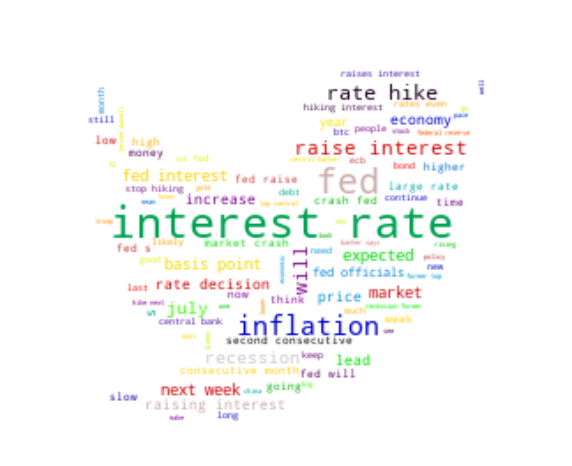

In [21]:
# Create a Word Cloud
allWords = " ".join( [tweets for tweets in df['full_text']])
mask = np.array(Image.open("twitter_logo.png"))


wordClouds = wordcloud.WordCloud(random_state = 21,
                                 background_color = "white",
                                 colormap='nipy_spectral',
                                 max_font_size = 50,
                                 max_words = 500,
                                 mask = mask).generate(allWords)
plt.figure(figsize=[10,10])
plt.imshow(wordClouds, interpolation = "bilinear")
plt.axis("off")
plt.savefig('../images/masked_wordcloud.png')
plt.show()

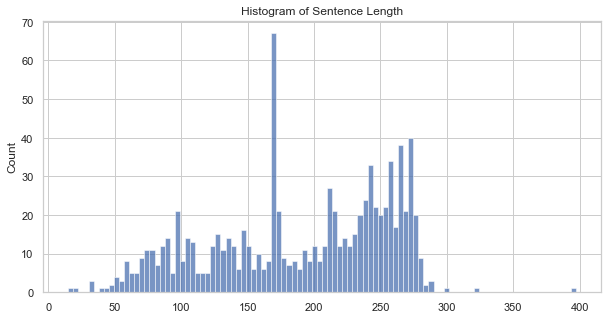

In [22]:
# Histogram of Text Lengths
plt.figure(figsize=(10, 5))
sns.set_theme(style="whitegrid")
sns.histplot([len(s) for s in df['full_text']], bins=100)
plt.title('Histogram of Sentence Length')
plt.savefig("../images/length_histogram.png")
plt.show()

HF_SentimentLabel
Negative    328
Neutral     536
Positive     36
Name: id, dtype: int64

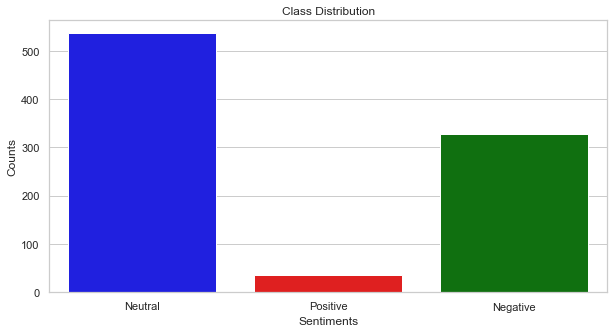

In [24]:
# Count of HF Sentiment
plt.figure(figsize=(10, 5))
c = ["Blue", "Red", "Green"]
sns.set_theme(style="whitegrid")

sns.countplot(x = df.HF_SentimentLabel, data = df, palette = c)
plt.title('Class Distribution')
plt.xlabel("Sentiments")
plt.ylabel("Counts")
plt.savefig("../images/class_distribution_sentiment.png")

df.groupby(['HF_SentimentLabel'])["id"].count() ## Large class imbalance

TB_SentimentLabel
Negative      4
Neutral     871
Positive     25
Name: id, dtype: int64

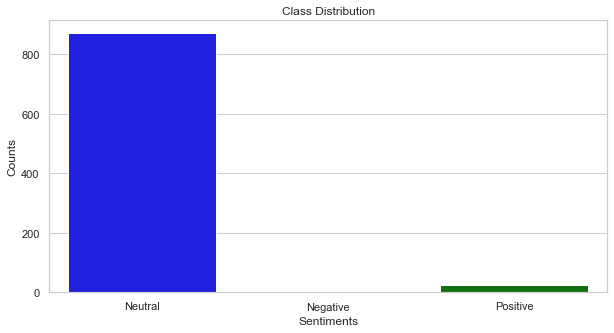

In [25]:
# Count of TB Sentiment
plt.figure(figsize=(10, 5))
c = ["Blue", "Red", "Green"]
sns.set_theme(style="whitegrid")

sns.countplot(x = df.TB_SentimentLabel, data = df, palette = c)
plt.title('Class Distribution')
plt.xlabel("Sentiments")
plt.ylabel("Counts")
plt.savefig("../images/class_distribution_sentiment_TB.png")

df.groupby(['TB_SentimentLabel'])["id"].count() ## Large class imbalance - no negative statements? 

HF_EmotionLabel
Anger       150
Joy         270
Optimism     84
Sadness     396
Name: id, dtype: int64

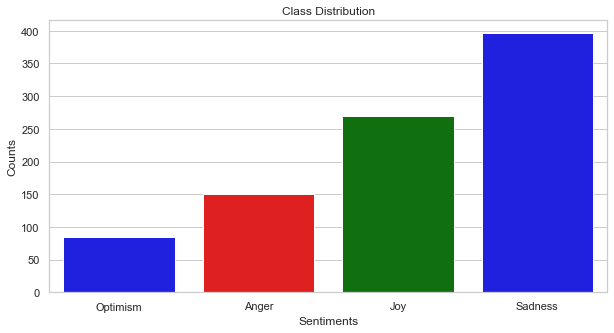

In [26]:
# Count of HF Emotion
plt.figure(figsize=(10, 5))
c = ["Blue", "Red", "Green"]
sns.set_theme(style="whitegrid")

sns.countplot(x = df.HF_EmotionLabel, data = df, palette = c)
plt.title('Class Distribution')
plt.xlabel("Sentiments")
plt.ylabel("Counts")
plt.savefig("../images/class_distribution_emotion.png")

df.groupby(['HF_EmotionLabel'])["id"].count() ## Large class imbalance in the emotions as well

HF_IronyLabel
Irony        217
Not_Irony    683
Name: id, dtype: int64

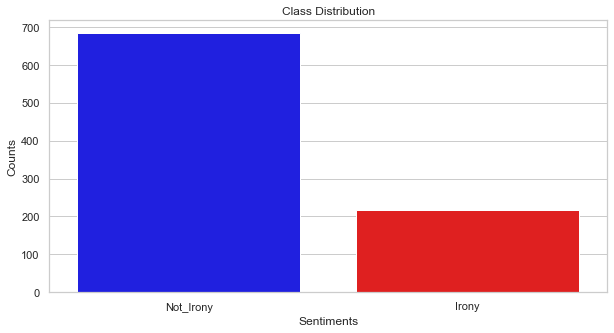

In [27]:
# Count of HF Irony
plt.figure(figsize=(10, 5))
c = ["Blue", "Red", "Green"]
sns.set_theme(style="whitegrid")

sns.countplot(x = df.HF_IronyLabel, data = df, palette = c)
plt.title('Class Distribution')
plt.xlabel("Sentiments")
plt.ylabel("Counts")
plt.savefig("../images/class_distribution_emotion_TB.png")

df.groupby(['HF_IronyLabel'])["id"].count() ## Large class imbalance 

HF_OffensiveLabel
Not_Offensive    863
Offensive         37
Name: id, dtype: int64

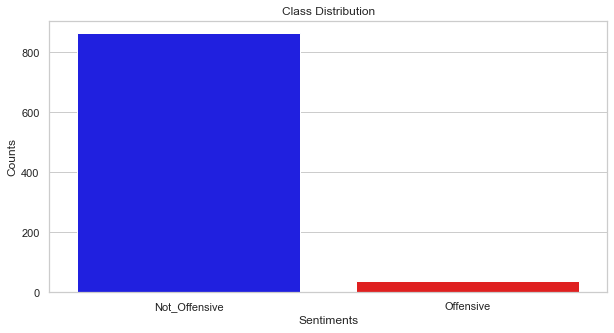

In [28]:
# Count of HF Offensive
plt.figure(figsize=(10, 5))
c = ["Blue", "Red", "Green"]
sns.set_theme(style="whitegrid")

sns.countplot(x = df.HF_OffensiveLabel, data = df, palette = c)
plt.title('Class Distribution')
plt.xlabel("Sentiments")
plt.ylabel("Counts")
plt.savefig("class_distribution.png")

df.groupby(['HF_OffensiveLabel'])["id"].count() ## Large class imbalance in the emotions as well

/Users/Jordan/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


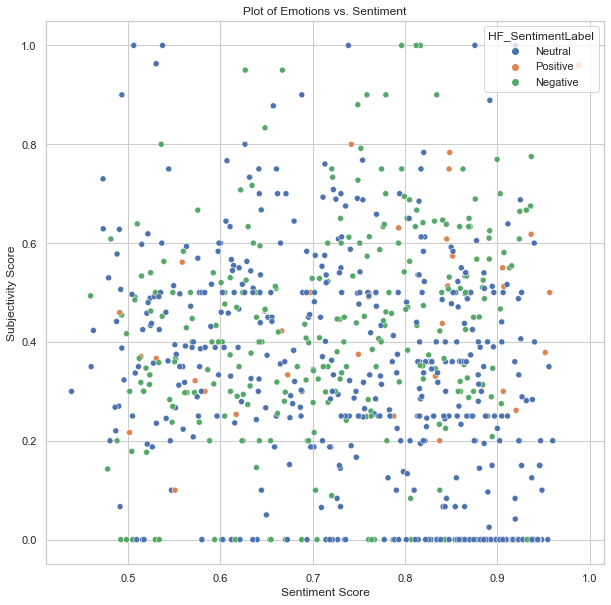

In [33]:
# Plot of HF_SentimentScore versus TB_SubjectivityScore by HF_SentimentLabel
plt.figure(figsize = (10,10))

sns.scatterplot('HF_SentimentScore', 'TB_SubjectivityScore', data=df, hue='HF_SentimentLabel')
    
plt.title("Plot of Subjectivity vs. Sentiment")
plt.xlabel("Sentiment Score")
plt.ylabel("Subjectivity Score")

plt.show()

/Users/Jordan/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


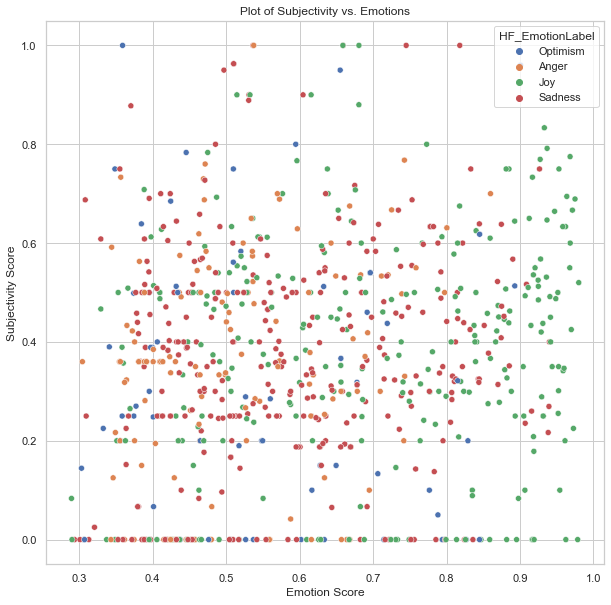

In [111]:
# Plot of HF_EmotionScore versus TB_SubjectivityScore by HF_SentimentLabel
plt.figure(figsize = (10,10))

sns.scatterplot('HF_EmotionScore', 'TB_SubjectivityScore', data=df, hue='HF_EmotionLabel')
    
plt.title("Plot of Subjectivity vs. Emotions")
plt.xlabel("Emotion Score")
plt.ylabel("Subjectivity Score")

plt.show()

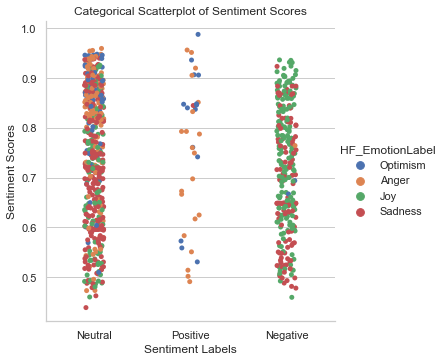

In [109]:
# Categorical scatterplot of sentiment scores by label and emotion
sns.catplot(x="HF_SentimentLabel", y="HF_SentimentScore", hue="HF_EmotionLabel", data = df)

plt.title("Categorical Scatterplot of Sentiment Scores")
plt.xlabel("Sentiment Labels")
plt.ylabel("Sentiment Scores")

plt.show()

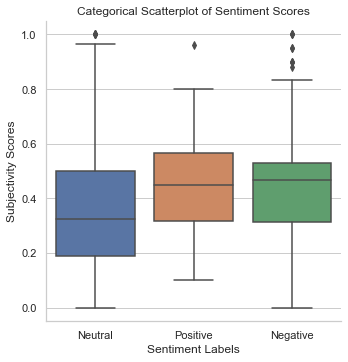

In [107]:
# Categorical scatterplot of subjectivity scores by label 
sns.catplot(x="HF_SentimentLabel", y="TB_SubjectivityScore", kind = "box", data = df)

plt.title("Categorical Scatterplot of Sentiment Scores")
plt.xlabel("Sentiment Labels")
plt.ylabel("Subjectivity Scores")

plt.show()

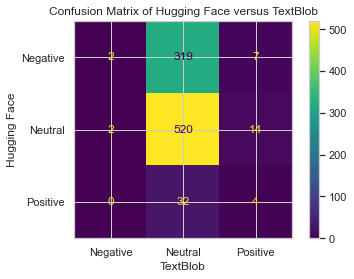

The accuracy is: 0.5844444444444444


In [81]:
# Confusion matrix of HF and TB tweet sentiments labels

from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(df["HF_SentimentLabel"], df["TB_SentimentLabel"])

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, 
                                            display_labels = ['Negative', 'Neutral', 'Positive'])
cm_display.plot()
plt.title("Confusion Matrix of Hugging Face versus TextBlob")
plt.ylabel("Hugging Face")
plt.xlabel("TextBlob")
plt.savefig("../images/confusion_matrix.png")
plt.show()

accuracy = metrics.accuracy_score(df["HF_SentimentLabel"], df["TB_SentimentLabel"])
print("The accuracy is: " + str(accuracy))

## We see that Hugging Face provides a lot more diverse guesses than TextBlob which is often neutral sentiments

# Visualizations of Results - Numeric

Contents:
1. Time stamps for tweets by sentiment
2. Summary of sentiment scores by label - HF
3. Summary of sentiment scores by label - TB
4. Summary of emotion scores by label
5. Summary of emotion scores by sentiment
6. Summary of irony scores by label
7. Summary of irony scores by sentiment
8. Summary of offensive scores by label
9. Summary of offensive scores by sentiment
10. Summary of irony labels by offensive labels
11. Mean retweets by sentiment
12. Max retweets by sentiment
13. Mean retweets by emotion
14. Max retweets by emotion
15. Mean favorites by sentiment
16. Max favorites by sentiment
17. Mean favorites by emotion
18. Max favorites by emotion

In [58]:
# Earliest and Latest Recorded Time Stamps for each Tweet sentiment
print(df.groupby(["HF_SentimentLabel"])[["created_at"]].min())
print(df.groupby(["HF_SentimentLabel"])[["created_at"]].max())

                                  created_at
HF_SentimentLabel                           
Negative           2022-07-22 08:44:21+00:00
Neutral            2022-07-22 08:04:42+00:00
Positive           2022-07-22 10:58:42+00:00
                                  created_at
HF_SentimentLabel                           
Negative           2022-07-25 18:32:14+00:00
Neutral            2022-07-25 18:32:53+00:00
Positive           2022-07-25 11:45:17+00:00


In [68]:
# Summary of HF sentiment scores
df.groupby(['HF_SentimentLabel'])['HF_SentimentScore'].describe()

,count,mean,std,min,25%,50%,75%,max
HF_SentimentLabel,,,,,,,,
Negative,328.0,0.708899,0.118810,0.459293,0.635296,0.697496,0.806139,0.936751
Neutral,536.0,0.747733,0.133470,0.438630,0.634571,0.767371,0.864763,0.959864
Positive,36.0,0.755248,0.148284,0.490815,0.622896,0.790308,0.849187,0.988144


In [70]:
# Summary of TB sentiment scores
df.groupby(['TB_SentimentLabel'])['TB_SentimentScore'].describe()

,count,mean,std,min,25%,50%,75%,max
TB_SentimentLabel,,,,,,,,
Negative,4.0,-0.616667,0.088192,-0.700000,-0.675,-0.633333,-0.575000,-0.500000
Neutral,871.0,0.062595,0.148637,-0.416667,0.000,0.022857,0.164907,0.442857
Positive,25.0,0.601500,0.151826,0.500000,0.500,0.512500,0.600000,1.000000


In [67]:
# Summary of HF emotion scores
df.groupby(['HF_EmotionLabel'])['HF_EmotionScore'].describe()

,count,mean,std,min,25%,50%,75%,max
HF_EmotionLabel,,,,,,,,
Anger,150.0,0.503087,0.123119,0.304462,0.404889,0.469788,0.572750,0.859846
Joy,270.0,0.699648,0.192713,0.289625,0.525681,0.716280,0.881694,0.979972
Optimism,84.0,0.560861,0.162541,0.303236,0.405149,0.542765,0.696294,0.900792
Sadness,396.0,0.587311,0.142580,0.293834,0.484451,0.556708,0.674401,0.939992


In [62]:
# Summary of emotion by tweet sentiments
df.groupby(['HF_EmotionLabel'])['HF_SentimentLabel'].describe()

,count,unique,top,freq
HF_EmotionLabel,,,,
Anger,150,3,Neutral,127
Joy,270,2,Negative,168
Optimism,84,3,Neutral,68
Sadness,396,3,Neutral,239


In [74]:
# Summary of HF irony scores
df.groupby(['HF_IronyLabel'])['HF_IronyScore'].describe()

,count,mean,std,min,25%,50%,75%,max
HF_IronyLabel,,,,,,,,
Irony,217.0,0.717220,0.126179,0.503161,0.613541,0.712767,0.823999,0.958012
Not_Irony,683.0,0.844621,0.134196,0.503871,0.763411,0.893512,0.949796,0.994787


In [63]:
# Summary of Irony by tweet sentiments
df.groupby(['HF_IronyLabel'])['HF_SentimentLabel'].describe()

,count,unique,top,freq
HF_IronyLabel,,,,
Irony,217,3,Neutral,142
Not_Irony,683,3,Neutral,394


In [75]:
# Summary of offensive by scores
df.groupby(['HF_OffensiveLabel'])['HF_OffensiveScore'].describe()

,count,mean,std,min,25%,50%,75%,max
HF_OffensiveLabel,,,,,,,,
Not_Offensive,863.0,0.820001,0.069099,0.501203,0.784427,0.836343,0.868098,0.942011
Offensive,37.0,0.672646,0.117487,0.506711,0.572183,0.643684,0.777675,0.901800


In [64]:
# Summary of offensive by tweet sentiments
df.groupby(['HF_OffensiveLabel'])['HF_SentimentLabel'].describe()

,count,unique,top,freq
HF_OffensiveLabel,,,,
Not_Offensive,863,3,Neutral,534
Offensive,37,2,Negative,35


In [125]:
# Summary of offensive by tweet sentiments
df.groupby(['HF_IronyLabel'])['HF_OffensiveLabel'].describe()

,count,unique,top,freq
HF_IronyLabel,,,,
Irony,217,2,Not_Offensive,209
Not_Irony,683,2,Not_Offensive,654


In [76]:
# Mean number of retweets by tweet sentiment
df.groupby(["HF_SentimentLabel"])[["retweets"]].mean()

,retweets
HF_SentimentLabel,
Negative,3.914634
Neutral,0.906716
Positive,3.583333


In [61]:
# Max number of retweets by tweet sentiment
df.groupby(["HF_SentimentLabel"])[["retweets"]].max()

,retweets
analysisLabel,
negative,216
neutral,21
positive,16


In [77]:
# Mean number of retweets by tweet emotion
df.groupby(["HF_EmotionLabel"])[["retweets"]].mean()

,retweets
HF_EmotionLabel,
Anger,1.413333
Joy,0.662963
Optimism,3.202381
Sadness,3.128788


In [78]:
# Max number of retweets by tweet emotion
df.groupby(["HF_EmotionLabel"])[["retweets"]].max()

,retweets
HF_EmotionLabel,
Anger,105
Joy,61
Optimism,241
Sadness,1024


In [79]:
# Mean number of favorites by tweet sentiment
df.groupby(["HF_SentimentLabel"])[["favorites"]].mean()

,favorites
HF_SentimentLabel,
Negative,17.820122
Neutral,4.395522
Positive,19.416667


In [80]:
# Max nmber of favorites by tweet sentiment
df.groupby(["HF_SentimentLabel"])[["favorites"]].max()

,favorites
HF_SentimentLabel,
Negative,4265
Neutral,806
Positive,560


In [82]:
# Mean number of favorites by tweet emotion
df.groupby(["HF_EmotionLabel"])[["favorites"]].mean()

,favorites
HF_EmotionLabel,
Anger,7.293333
Joy,5.896296
Optimism,11.511905
Sadness,13.250000


In [83]:
# Max number of favorites by tweet emotion
df.groupby(["HF_EmotionLabel"])[["favorites"]].max()

,favorites
HF_EmotionLabel,
Anger,560
Joy,541
Optimism,806
Sadness,4265


# Investigating Negative Sentiment, Joy Emotion Tweets for Deeper Understanding

In [127]:
# Print out some of the Joy, Negative comments for further investigation
subset = df[df.HF_EmotionLabel == "Joy"]
subset = subset[subset.HF_SentimentLabel == "Negative"]

print("There are " + str(subset.id.count()) + " Joy emotion, Negative sentiment tweets.") # Should match from above analysis

subset.head()

There are 168 Joy emotion, Negative sentiment tweets.


,Unnamed: 0,id,full_text,favorites,retweets,created_at,HF_Sentiment,HF_Emotion,HF_Irony,HF_Offensive,...,HF_EmotionLabel,HF_EmotionScore,HF_IronyLabel,HF_IronyScore,HF_OffensiveLabel,HF_OffensiveScore,TB_SentimentScore,TB_SubjectivityScore,TB_SentimentLabel,TB_SubjectivityLabel
2,2,1551564226057076739,this chart basically explaining why all notion...,496,46,2022-07-25 13:45:12+00:00,"[{'label': 'Negative', 'score': 0.639105618000...","[{'label': 'joy', 'score': 0.5617653131484985}]","[{'label': 'LABEL_1', 'score': 0.7366797924041...","[{'label': 'LABEL_0', 'score': 0.7770044207572...",...,Joy,0.561765,Not_Irony,0.736680,Not_Offensive,0.777004,0.250000,0.500000,Neutral,Subjective
5,5,1551636458599075843,sen elizabeth warren rips the fed for using bl...,0,0,2022-07-25 18:32:14+00:00,"[{'label': 'Negative', 'score': 0.806727707386...","[{'label': 'joy', 'score': 0.7333800196647644}]","[{'label': 'LABEL_1', 'score': 0.9855027198791...","[{'label': 'LABEL_0', 'score': 0.6707200407981...",...,Joy,0.733380,Not_Irony,0.985503,Not_Offensive,0.670720,0.000000,0.000000,Neutral,Subjective
10,10,1551635622401642496,bidenflation blame biden bidengashike repe...,0,0,2022-07-25 18:28:55+00:00,"[{'label': 'Negative', 'score': 0.814004182815...","[{'label': 'joy', 'score': 0.7973108291625977}]","[{'label': 'LABEL_0', 'score': 0.6713271737098...","[{'label': 'LABEL_0', 'score': 0.5391991138458...",...,Joy,0.797311,Irony,0.671327,Not_Offensive,0.539199,0.000000,0.000000,Neutral,Subjective
12,12,1551635341232193537,elizabeth warren criticizes the fed’s ‘aggress...,0,0,2022-07-25 18:27:47+00:00,"[{'label': 'Negative', 'score': 0.593762576580...","[{'label': 'joy', 'score': 0.8469892144203186}]","[{'label': 'LABEL_1', 'score': 0.8687078356742...","[{'label': 'LABEL_0', 'score': 0.8164584636688...",...,Joy,0.846989,Not_Irony,0.868708,Not_Offensive,0.816458,0.000000,0.000000,Neutral,Subjective
18,18,1551187038828994560,so unemployment is low wages are rising and ...,9,0,2022-07-24 12:46:24+00:00,"[{'label': 'Negative', 'score': 0.907103002071...","[{'label': 'joy', 'score': 0.6337039470672607}]","[{'label': 'LABEL_1', 'score': 0.8532509803771...","[{'label': 'LABEL_0', 'score': 0.6134825944900...",...,Joy,0.633704,Not_Irony,0.853251,Not_Offensive,0.613483,-0.082727,0.580909,Neutral,Objective


Out of curiousity, I want to see if the people who are tweeting such weird emotion and sentiment labels are unique or not. We set up a way to count the number of unique ID values that are seen in the subset.

In [138]:
input_list = subset['id'].unique()

#empty list to store unique values
empty_list = [] 

#counter variable to count unique values
count = 0

# travesing the array 
for ele in input_list:
    if(ele not in empty_list):
        count += 1
        empty_list.append(ele) 

#output
print("Count of unique user ID values are:", count)

Count of unique user ID values are: 168


Each of the entries in the dataset comes from a unique Twitter user. Research shows that people who use sarcasm are more likely to use sarcasm in future interactions; meaning if certain NLP models are trained to use sarcasm and these are deemed as sarcastic tweets saving their ID number as an input could help future models. 


The next step is to explore the data and see if any unique patterns start to emerge in this subset.

/Users/Jordan/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


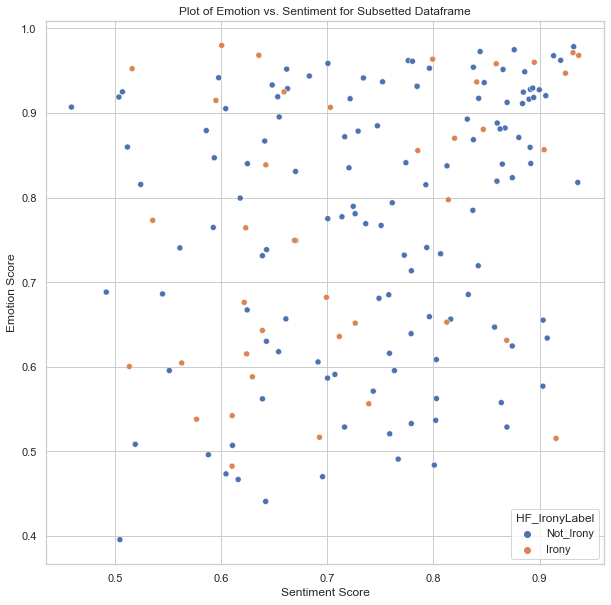

In [139]:
## Looking first at the scores for emotion and sentiment
# Plot of HF_SentimentScore versus HF_EmotionScore
plt.figure(figsize = (10,10))

sns.scatterplot('HF_SentimentScore', 'HF_EmotionScore', data=subset, hue='HF_IronyLabel')
    
plt.title("Plot of Emotion vs. Sentiment for Subsetted Dataframe")
plt.xlabel("Sentiment Score")
plt.ylabel("Emotion Score")

plt.show()

The above is a scatterplot of the emotion score versus the sentiment score by irony label. We see some emerging patterns as increasing the sentiment score also increases the emotion score for tweets labeled as ironic. Meaning, that as we grow more confident in the labeling from the sentiment, we also grow more confident in the label for the emotion for ironic tweets. 

/Users/Jordan/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:3775: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try pointplot
  warnings.warn(msg, UserWarning)
/Users/Jordan/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:3775: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try pointplot
  warnings.warn(msg, UserWarning)


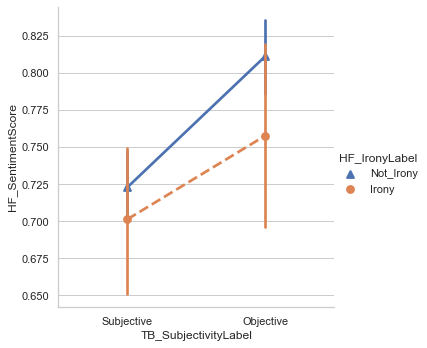

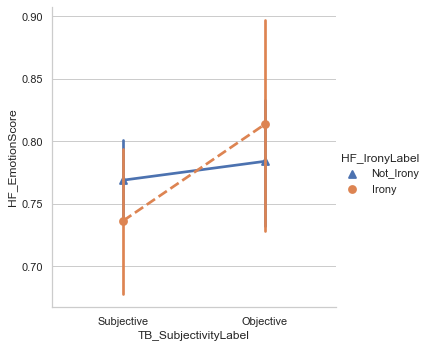

In [143]:
sns.catplot(x="TB_SubjectivityLabel", y="HF_SentimentScore", hue="HF_IronyLabel",
            markers=["^", "o"], linestyles=["-", "--"],
            kind="point", data=subset, ax = ax1)

sns.catplot(x="TB_SubjectivityLabel", y="HF_EmotionScore", hue="HF_IronyLabel",
            markers=["^", "o"], linestyles=["-", "--"],
            kind="point", data=subset, ax = ax2)

Looking at the graphs we see that tweets labeled objective tend to score higher sentiment and emotion scores than there subjective counterparts.

### Detecting Sarcasm with a transfered Naive Bayes model

The dataset Sarcasm.json comes from a labeled Kaggle dataset. I will be training a Bernoulli Naive Bayes model to predict whether or not a tweet is sarcastic, then I will be using this model to make predictions on the subsetted dataset. 

Other models of potential interest for detecting sarcasm include: SVM, RF, and DNN (especially LSTM and CNN). 

In [147]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB

# Importing the json file and labeling dataset
datum = pd.read_json("Sarcasm.json", lines=True)
datum["is_sarcastic"] = datum["is_sarcastic"].map({0: "Not Sarcasm", 1: "Sarcasm"})
print(datum.head())

                                        article_link  \
0  https://www.huffingtonpost.com/entry/versace-b...   
1  https://www.huffingtonpost.com/entry/roseanne-...   
2  https://local.theonion.com/mom-starting-to-fea...   
3  https://politics.theonion.com/boehner-just-wan...   
4  https://www.huffingtonpost.com/entry/jk-rowlin...   

                                            headline is_sarcastic  
0  former versace store clerk sues over secret 'b...  Not Sarcasm  
1  the 'roseanne' revival catches up to our thorn...  Not Sarcasm  
2  mom starting to fear son's web series closest ...      Sarcasm  
3  boehner just wants wife to listen, not come up...      Sarcasm  
4  j.k. rowling wishes snape happy birthday in th...  Not Sarcasm  


In [152]:
# Create training and testing split
datum = datum[["headline", "is_sarcastic"]]
x = np.array(datum["headline"])
y = np.array(datum["is_sarcastic"])

cv = CountVectorizer()
X = cv.fit_transform(x) # Fit the Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Fit Bernoulli Naive Bayes model
model = BernoulliNB()
model.fit(X_train, y_train)
print("The accuracy for the test model is: " + str(model.score(X_test, y_test)))


The accuracy for the test model is: 0.8448146761512542


In [156]:
# Transfer trained NB model to use on full text
full_text = subset['full_text']
data = cv.transform(full_text).toarray()
subset['NB_SarcasmLabel'] = model.predict(data)
subset.head()

,Unnamed: 0,id,full_text,favorites,retweets,created_at,HF_Sentiment,HF_Emotion,HF_Irony,HF_Offensive,...,HF_EmotionScore,HF_IronyLabel,HF_IronyScore,HF_OffensiveLabel,HF_OffensiveScore,TB_SentimentScore,TB_SubjectivityScore,TB_SentimentLabel,TB_SubjectivityLabel,NB_SarcasmLabel
2,2,1551564226057076739,this chart basically explaining why all notion...,496,46,2022-07-25 13:45:12+00:00,"[{'label': 'Negative', 'score': 0.639105618000...","[{'label': 'joy', 'score': 0.5617653131484985}]","[{'label': 'LABEL_1', 'score': 0.7366797924041...","[{'label': 'LABEL_0', 'score': 0.7770044207572...",...,0.561765,Not_Irony,0.736680,Not_Offensive,0.777004,0.250000,0.500000,Neutral,Subjective,Not Sarcasm
5,5,1551636458599075843,sen elizabeth warren rips the fed for using bl...,0,0,2022-07-25 18:32:14+00:00,"[{'label': 'Negative', 'score': 0.806727707386...","[{'label': 'joy', 'score': 0.7333800196647644}]","[{'label': 'LABEL_1', 'score': 0.9855027198791...","[{'label': 'LABEL_0', 'score': 0.6707200407981...",...,0.733380,Not_Irony,0.985503,Not_Offensive,0.670720,0.000000,0.000000,Neutral,Subjective,Not Sarcasm
10,10,1551635622401642496,bidenflation blame biden bidengashike repe...,0,0,2022-07-25 18:28:55+00:00,"[{'label': 'Negative', 'score': 0.814004182815...","[{'label': 'joy', 'score': 0.7973108291625977}]","[{'label': 'LABEL_0', 'score': 0.6713271737098...","[{'label': 'LABEL_0', 'score': 0.5391991138458...",...,0.797311,Irony,0.671327,Not_Offensive,0.539199,0.000000,0.000000,Neutral,Subjective,Not Sarcasm
12,12,1551635341232193537,elizabeth warren criticizes the fed’s ‘aggress...,0,0,2022-07-25 18:27:47+00:00,"[{'label': 'Negative', 'score': 0.593762576580...","[{'label': 'joy', 'score': 0.8469892144203186}]","[{'label': 'LABEL_1', 'score': 0.8687078356742...","[{'label': 'LABEL_0', 'score': 0.8164584636688...",...,0.846989,Not_Irony,0.868708,Not_Offensive,0.816458,0.000000,0.000000,Neutral,Subjective,Not Sarcasm
18,18,1551187038828994560,so unemployment is low wages are rising and ...,9,0,2022-07-24 12:46:24+00:00,"[{'label': 'Negative', 'score': 0.907103002071...","[{'label': 'joy', 'score': 0.6337039470672607}]","[{'label': 'LABEL_1', 'score': 0.8532509803771...","[{'label': 'LABEL_0', 'score': 0.6134825944900...",...,0.633704,Not_Irony,0.853251,Not_Offensive,0.613483,-0.082727,0.580909,Neutral,Objective,Not Sarcasm


In [162]:
# Sarcasm by irony
subset.groupby(["NB_SarcasmLabel"])[["HF_IronyLabel"]].describe()

HF_IronyLabel                       
                        count unique        top freq
NB_SarcasmLabel                                     
Not Sarcasm               136      2  Not_Irony  107
Sarcasm                    32      2  Not_Irony   21

In [163]:
# Sarcasm by offensive
subset.groupby(["NB_SarcasmLabel"])[["HF_OffensiveLabel"]].describe()

HF_OffensiveLabel                           
                            count unique            top freq
NB_SarcasmLabel                                             
Not Sarcasm                   136      2  Not_Offensive  111
Sarcasm                        32      2  Not_Offensive   24

/Users/Jordan/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


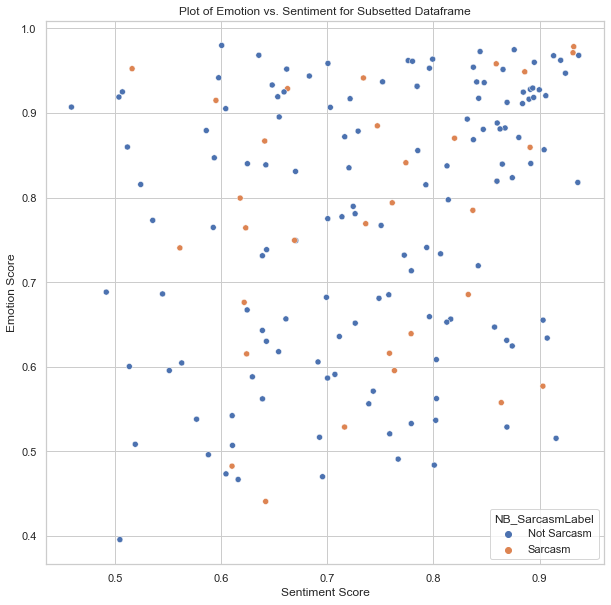

In [166]:
# Emotion and Sentiment scores by sarcasm
plt.figure(figsize = (10,10))

sns.scatterplot('HF_SentimentScore', 'HF_EmotionScore', data=subset, hue='NB_SarcasmLabel')
    
plt.title("Plot of Emotion vs. Sentiment for Subsetted Dataframe")
plt.xlabel("Sentiment Score")
plt.ylabel("Emotion Score")

plt.show()

/Users/Jordan/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:3775: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try pointplot
  warnings.warn(msg, UserWarning)
/Users/Jordan/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:3775: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try pointplot
  warnings.warn(msg, UserWarning)


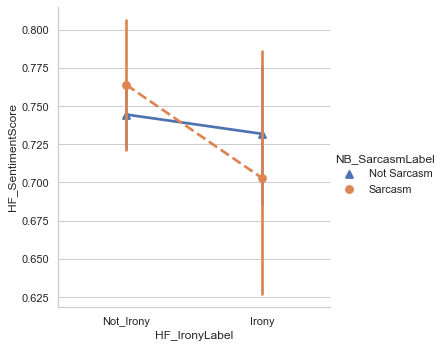

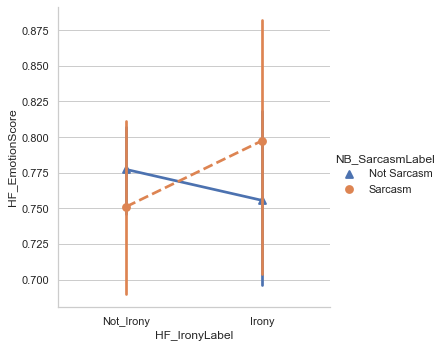

In [165]:
sns.catplot(x="HF_IronyLabel", y="HF_SentimentScore", hue="NB_SarcasmLabel",
            markers=["^", "o"], linestyles=["-", "--"],
            kind="point", data=subset, ax = ax1)

sns.catplot(x="HF_IronyLabel", y="HF_EmotionScore", hue="NB_SarcasmLabel",
            markers=["^", "o"], linestyles=["-", "--"],
            kind="point", data=subset, ax = ax2)

# Discussions

- API keys should be hidden in a config file. For simplicity / reproducibility that was not done here.


- There are a lot of immediate benefits to transition from NLTK to Hugging Face models - the biggest being the ability to quickly swap out models. As research into natural language processing continues, it is inevitable that models will become more sophisticated and produce better results. Transitioning to HF allows Regions to swap their models to those that are performing better than current SotA and fit into natural spaCy pipelines.


- Could we implement ensemble for sentiment analysis with little computation costs? Have a selection of models and choose the most popular label for the labeling as a way of increasing accuracy?


- In that same vein, it would be wise to investigate the accuracy of the HF models compared to the current NLTK anyways. Creating a labeled dataset would go a long way in being able to perform supervised learning and tuning a pretrained Hugging Face model to better suit Region's NLP data. In that similar vein, we could use transfer learning if created a labeled dataset would be too much of a hassle.


- A quick note about some edge case usages. Some sentences such as "I like the low interest rate, but I hate ..." will correctly get picked up as negative sentiments under the _cardiffnlp_ latest sentiment model used in analysis. However, sentence structrues like: "Your products are the best! It's a shame your customer service is bad!" get flagged as positive sentiment. I believe that it happens because of the tokenization process, as when you use "your product is best shame employee is rude" it correctly identifies as negative. For this reason, I believe that we need to fully investigate the AutoTokenization process that HF uses and decide if we would rather handle data preprocessing in house. If there are specific to Regions forms of tokenization/stemming/lemmatization that need to be done, it is likely they will not be done in the AutoTokenizer and could result in some mislabeling of edge cases.


- Collecting data over time could show additional insights about how trends in certain queries change over time. Negative sentiment towards the FED or interest rate woud change as the rates will decline.


- It is possible that the Joy emotion, Negative sentiment is either an "I told you so" mentality or sarcasm. If it is the later, transfer learning of other trained DL models could provide better accuracy than the basic NB model deployed here.


- Visualizations can be done in R. Save out the completed dataset to a CSV and upload to R with ggplot2 for a more advanced visualization suite. This might help gain additional insights.
